## Questions

- Is the energy and the power of the signal the same?! It's not because of the 1 / N constant
- why is the power interpreted as the variance of the signal?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import scipy.linalg as sl

%matplotlib inline
import matplotlib
import librosa as rosa
import sounddevice as sd

import os
import sys

sys.path.append("..")
from src import AudioSignal
from src import utils

## 2.1 Segmentation

In [2]:
female = AudioSignal(os.path.join(os.getcwd(), '../Exercise4', 'AudioFiles', 'female8khz.wav'))
female.play()

Successfully loaded audio signal from file: /home/p0w3r/gitrepos/ssp20/notebooks/../Exercise4/AudioFiles/female8khz.wav


In [3]:
frame_centers_ms, frames = female.get_frames(frame_length_ms=32, frame_shift_ms=8)

## 2.2 Signal power

In [4]:
power = utils.compute_power_in_time_domain(frames)

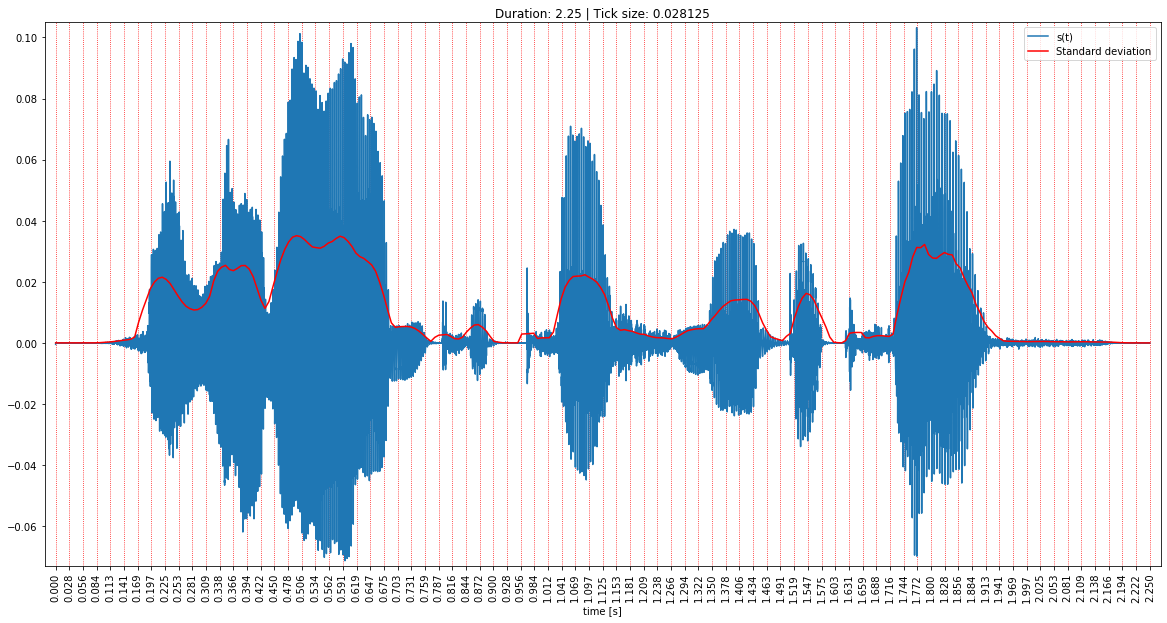

In [5]:
fig, axs = female.plot(return_plot=True)
t = np.linspace(0, female.duration_s, len(power))
axs.plot(t, np.sqrt(power), 'r', label='Standard deviation')
axs.legend()

## 2.3 Voiced / unvoiced decision

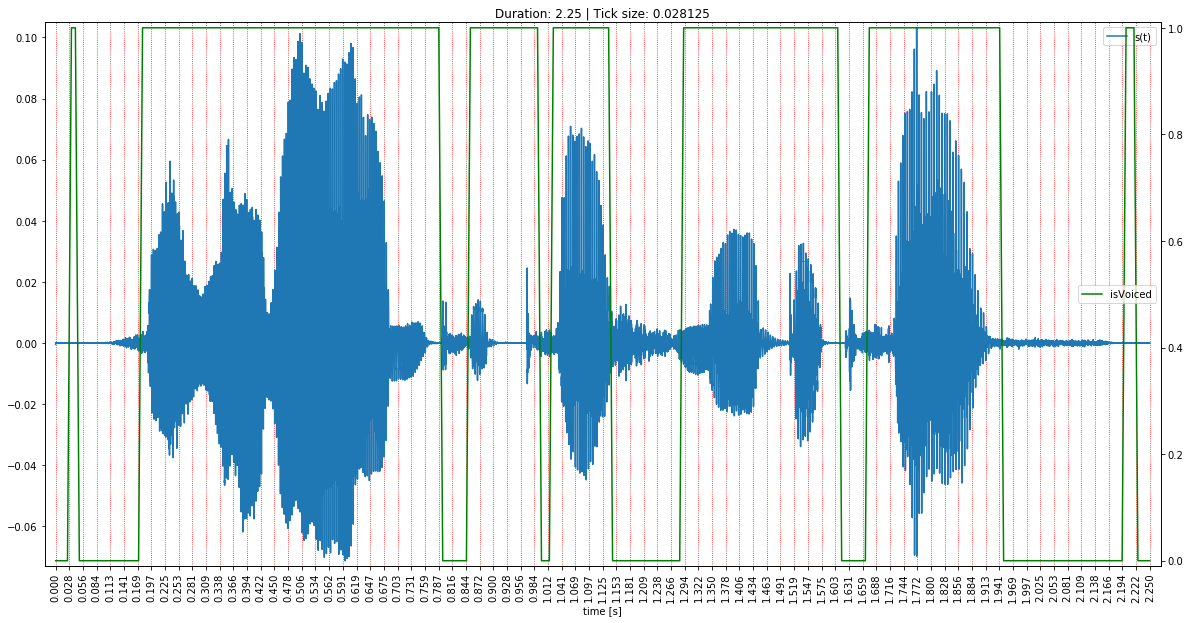

In [6]:
fig, axs = female.plot(return_plot=True)

is_voiced = utils.is_voiced(frames, threshold=.295)
t = np.linspace(0, female.duration_s, len(is_voiced))

axs2 = axs.twinx()
axs2.margins(x=0.01, y=0.01)
axs2.plot(t, is_voiced, 'g', label='isVoiced')
axs2.legend()

## 2.4 Fundamental frequency estimation

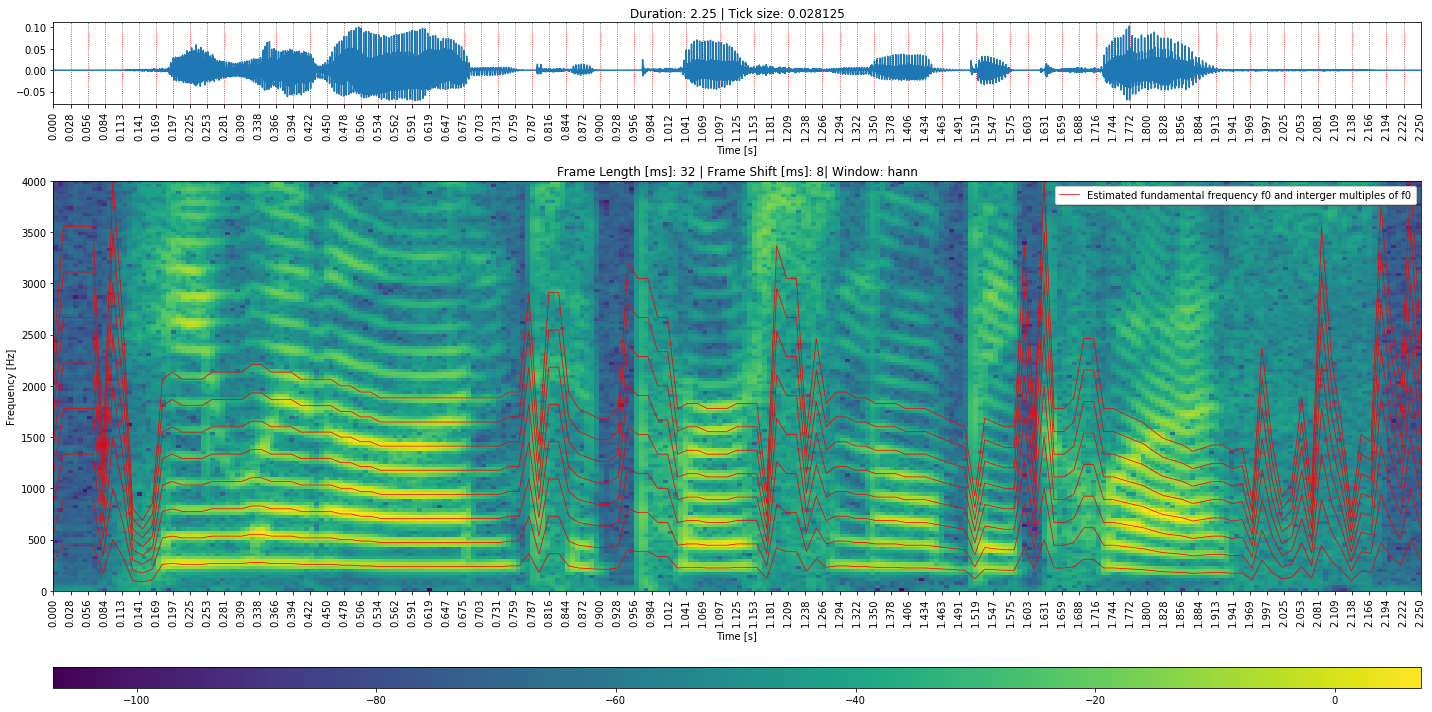

In [7]:
frame_length_ms=32
frame_shift_ms=8
stft, freq_axis, frame_centers_ms = female.compute_stft(frame_length_ms, frame_shift_ms)
fig, axs = female.plot_stft(stft, freq_axis, frame_centers_ms, frame_length_ms, frame_shift_ms, return_plot=True)


f0 = female.estimate_fundamental_freq()
t = np.linspace(0, female.duration_s, len(f0))
eff_plot = axs[1].plot(t, f0, color='r', linewidth=.75)
axs[1].legend((eff_plot), (['Estimated fundamental frequency f0 and interger multiples of f0']) , loc='upper right', shadow=True)
for i in range(2, 9):
    axs[1].plot(t, f0 * i, color='r', linewidth=.75)

## 2.5 Linear prediction coefficients / linear predictive coding

In [8]:
lpcs = utils.compute_lpc(frames, m=10)

## 3.1 LPCs and constant excitation signal

In [30]:
ex_voiced = utils.create_excitation_signal(female.duration_s * 1000, f0_hz=100, fs_hz=8000, voiced=True)
ex_unvoiced = utils.create_excitation_signal(female.duration_s * 1000, voiced=False)
assert len(ex_voiced.data) == len(ex_unvoiced.data)

Successfully loaded audio signal!
Successfully loaded audio signal!


278 278 278
Successfully loaded audio signal!


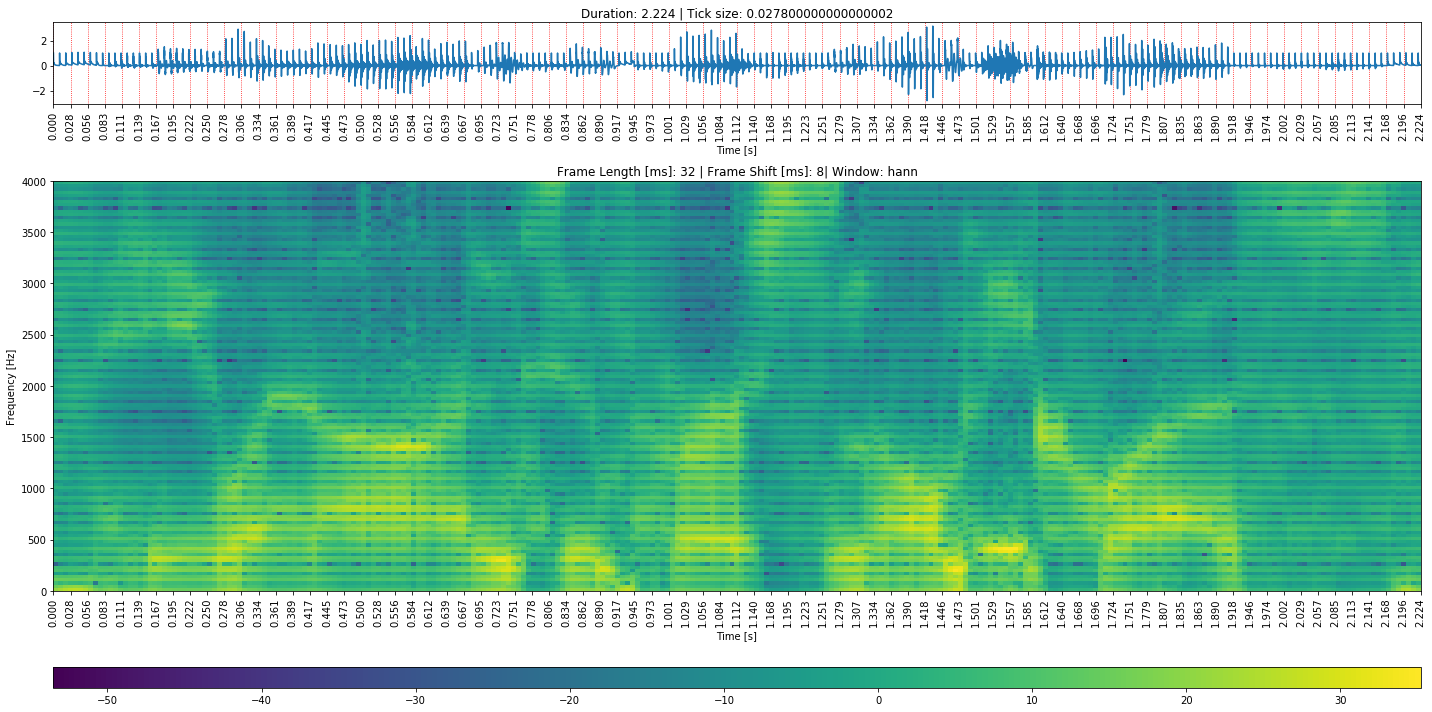

In [31]:
frame_centers_ms, ex_voiced_frames = ex_voiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_voiced_frames = ex_voiced_frames[:-3]
print(len(lpcs), len(ex_voiced_frames), len(frames))
filter_state_out = None
output = np.array([])
for frame, lpc in zip(ex_voiced_frames, lpcs):
    signal_out, filter_state_out = utils.filter_adaptively(np.array([1]), np.concatenate(([1], lpc)), frame, filter_state_out)
    output = np.append(output, signal_out)

output_sig = AudioSignal(data=output, sampling_freq_hz=8000)
output_sig.play()
output_sig.plot_stft(frame_length_ms=32, frame_shift_ms=8)

278 278 278
Successfully loaded audio signal!


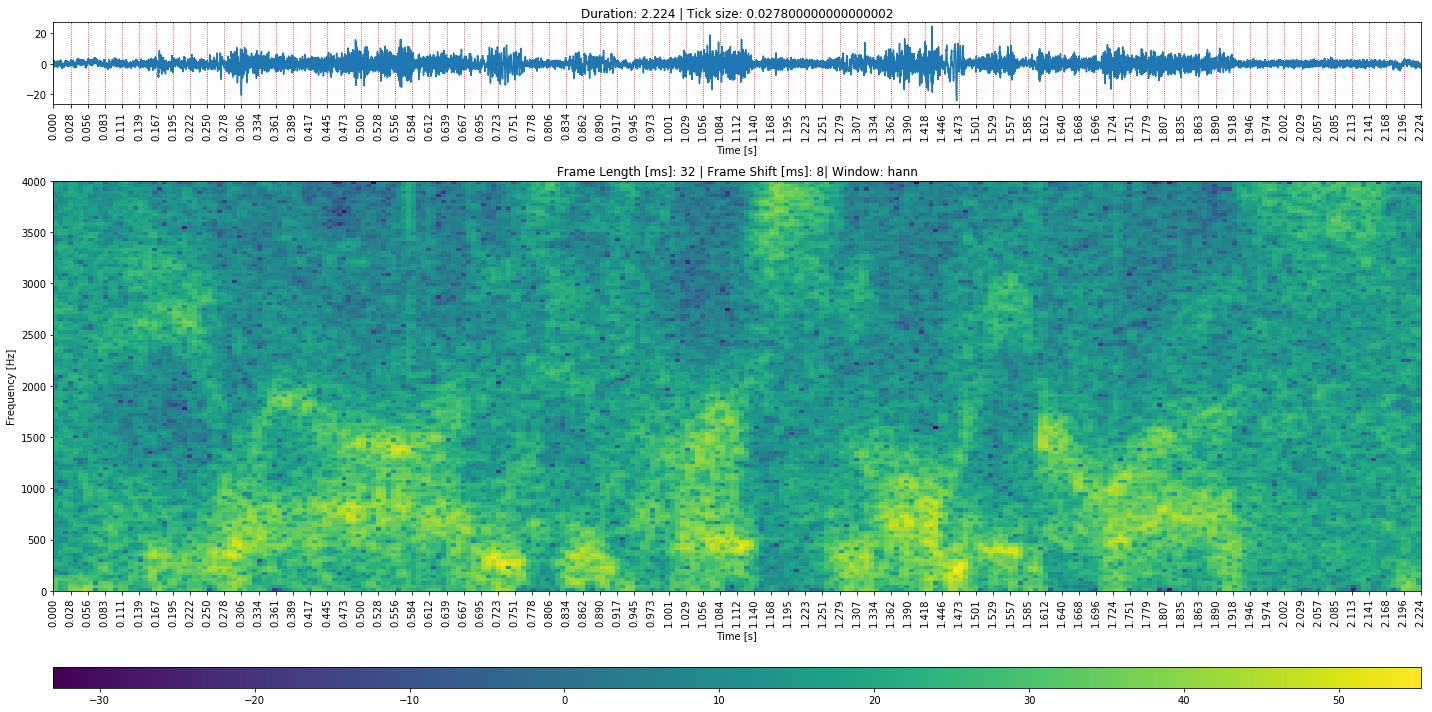

In [32]:
frame_centers_ms, ex_unvoiced_frames = ex_unvoiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_unvoiced_frames = ex_unvoiced_frames[:-3]
print(len(lpcs), len(ex_unvoiced_frames), len(frames))
filter_state_out = None
output = np.array([])
for frame, lpc in zip(ex_unvoiced_frames, lpcs):
    signal_out, filter_state_out = utils.filter_adaptively(np.array([1]), np.concatenate(([1], lpc)), frame, filter_state_out)
    output = np.append(output, signal_out)

output_sig = AudioSignal(data=output, sampling_freq_hz=8000)
output_sig.play()
output_sig.plot_stft(frame_length_ms=32, frame_shift_ms=8)

## 3.2 Voiced/unvoiced excitation

Successfully loaded audio signal!


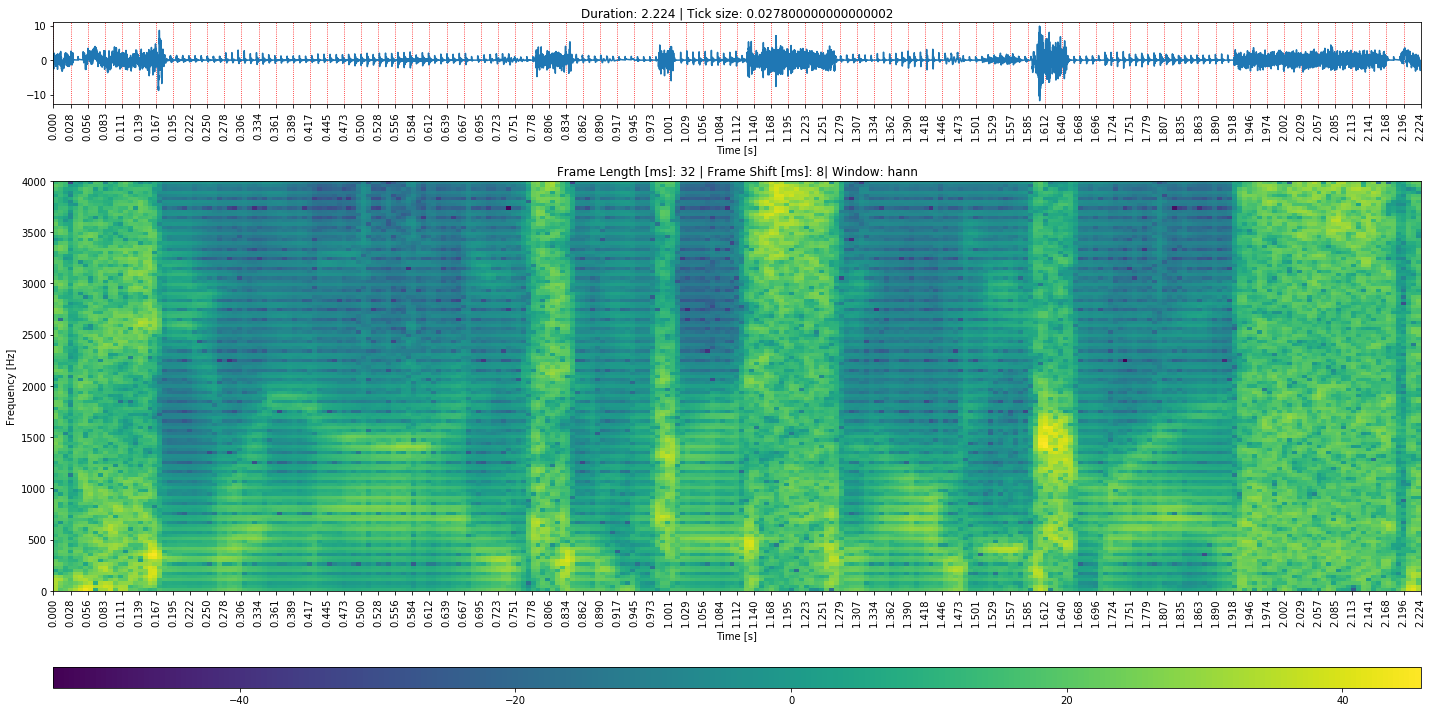

In [117]:
filter_state_out = None
output = np.array([])

_, ex_voiced_frames = ex_voiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_voiced_frames = ex_voiced_frames[:-3]

_, ex_unvoiced_frames = ex_unvoiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_unvoiced_frames = ex_unvoiced_frames[:-3]

for voiced_frame, unvoiced_frame, lpc, voiced in zip(ex_voiced_frames, ex_unvoiced_frames, lpcs, is_voiced):
    frame = voiced_frame
    if voiced == 0:
        frame = unvoiced_frame
    signal_out, filter_state_out = utils.filter_adaptively(np.array([1]), np.concatenate(([1], lpc)), frame, filter_state_out)
    output = np.append(output, signal_out)

output_sig = AudioSignal(data=output, sampling_freq_hz=8000)
output_sig.play()
output_sig.plot_stft(frame_length_ms=32, frame_shift_ms=8)

## 3.3 Amplitude modulation

Successfully loaded audio signal!


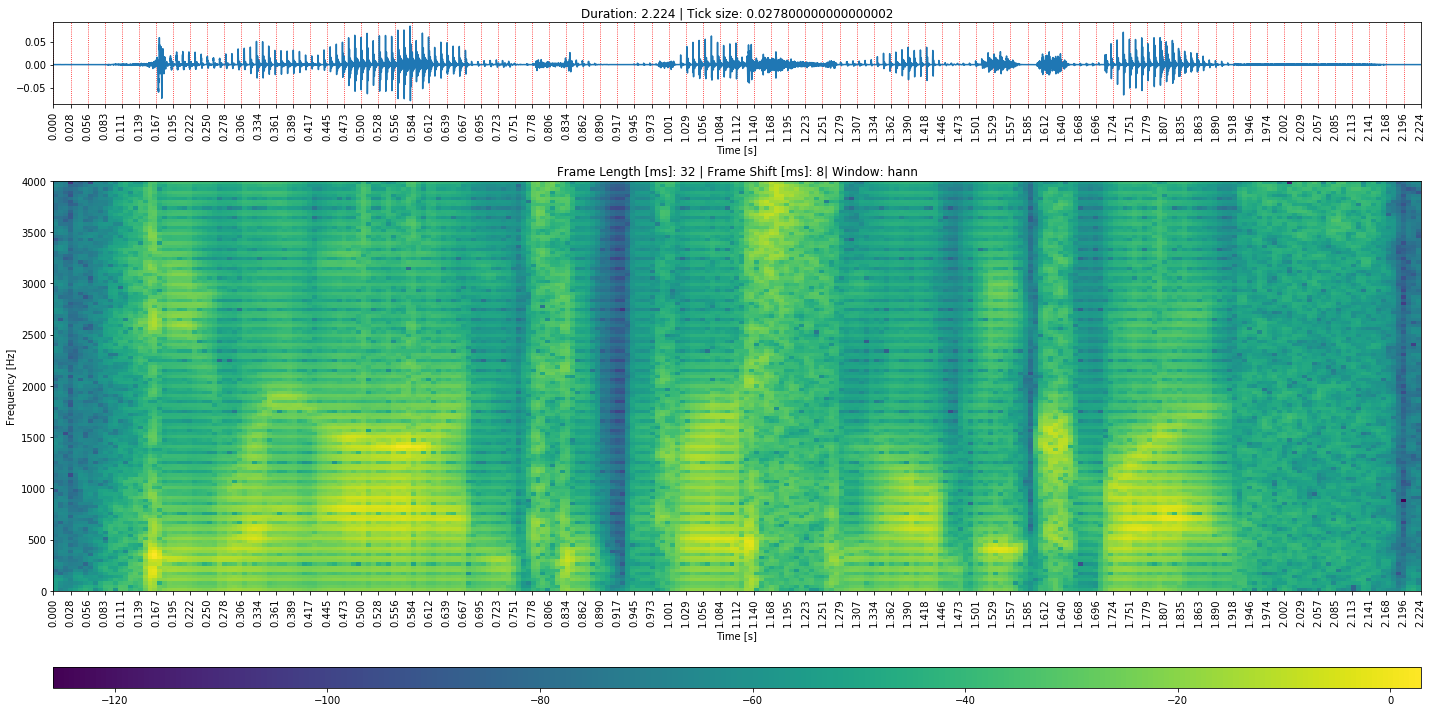

In [118]:
filter_state_out = None
output = np.array([])
_, ex_voiced_frames = ex_voiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_voiced_frames = ex_voiced_frames[:-3]

_, ex_unvoiced_frames = ex_unvoiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_unvoiced_frames = ex_unvoiced_frames[:-3]
for voiced_frame, unvoiced_frame, lpc, voiced, p in zip(ex_voiced_frames, ex_unvoiced_frames, lpcs, is_voiced, power):
    # voiced unvoiced decision
    frame = voiced_frame
    if voiced == 0:
        frame = unvoiced_frame
        
    # create synthesized signal by convolving the excitation signal with the vocal tract filter (from the lpcs) 
    signal_out, filter_state_out = utils.filter_adaptively(np.array([1]), np.concatenate(([1], lpc)), frame, filter_state_out)
    
    # account for amplitude mod / gain
    signal_out = np.sqrt(p) * signal_out
    
    output = np.append(output, signal_out)

output_sig = AudioSignal(data=output, sampling_freq_hz=8000)
output_sig.play()
output_sig.plot_stft(frame_length_ms=32, frame_shift_ms=8)

## 3.4 Variable f0

Successfully loaded audio signal!


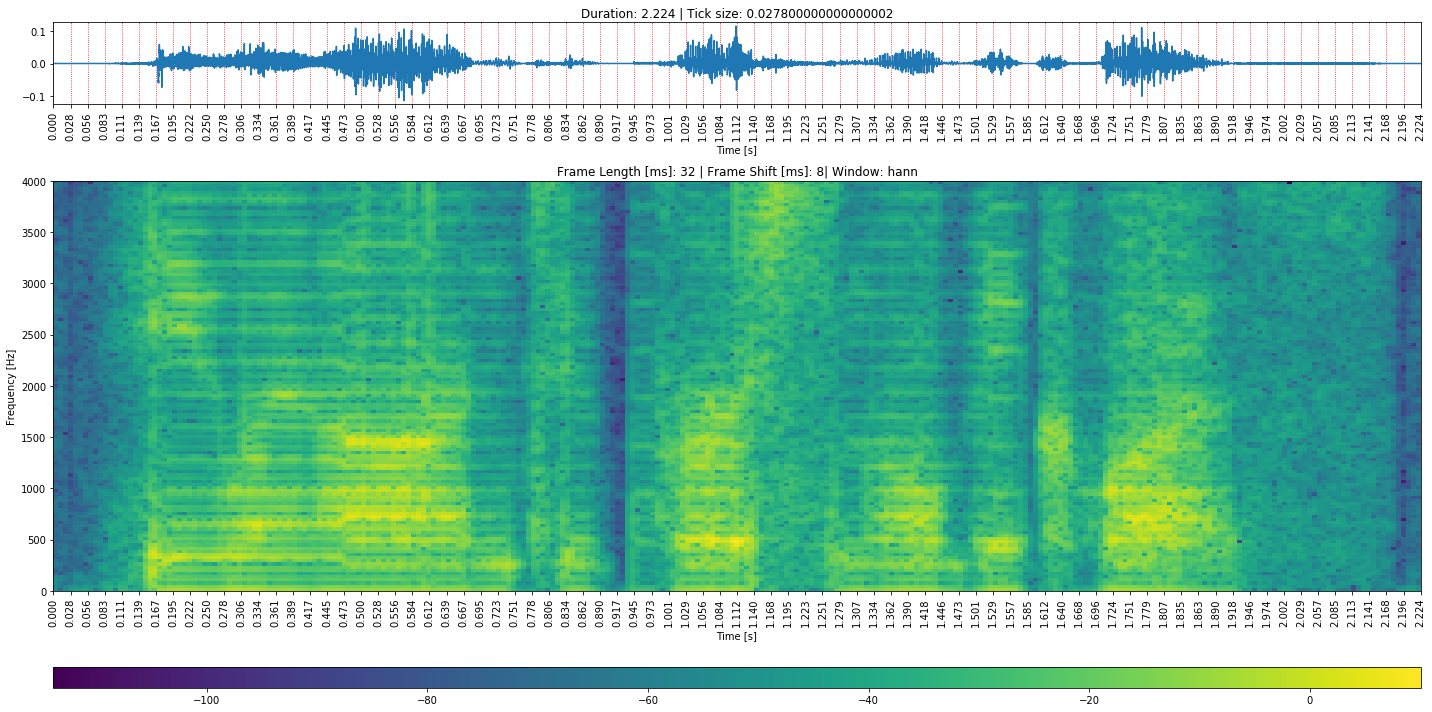

In [143]:
filter_state_out = None
output = np.array([])
# Create a counter ... 
f0_cnt = 0

_, ex_voiced_frames = ex_voiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_voiced_frames = ex_voiced_frames
_, ex_unvoiced_frames = ex_unvoiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_unvoiced_frames = ex_unvoiced_frames

fund_freq = female.estimate_fundamental_freq(frame_length_ms=8, frame_shift_ms=8)

for voiced_frame, unvoiced_frame, lpc, voiced, p, f0 in zip(ex_voiced_frames, ex_unvoiced_frames, lpcs, is_voiced, power, fund_freq):
    # voiced unvoiced decision
    frame = unvoiced_frame
    if voiced == 1:
        frame = voiced_frame
        # variable f0
        for i in range(len(voiced_frame)):
            # ... that you increase for every sample of a voiced segment.
            f0_cnt += 1
            # Test if the counter is larger than the current fundamental period in samples.
            if f0_cnt > utils.hz_to_idx(f0, female.sampling_freq):
                # Every time this is the case, set the counter to zero ...
                f0_cnt = 0
                # ... and insert a pulse into the excitation signal at the
                # corresponding sample of the segment.
                frame[i] = 1
                
    # create synthesized signal by convolving the excitation signal with the vocal tract filter (from the lpcs) 
    signal_out, filter_state_out = utils.filter_adaptively(np.array([1]), np.concatenate(([1], lpc)), frame, filter_state_out)
    
    # account for amplitude mod / gain
    signal_out = np.sqrt(p) * signal_out
    
    output = np.append(output, signal_out)

output_sig = AudioSignal(data=output, sampling_freq_hz=8000)
output_sig.play()
output_sig.plot_stft(frame_length_ms=32, frame_shift_ms=8)

## 3.5 No LPC

Successfully loaded audio signal!


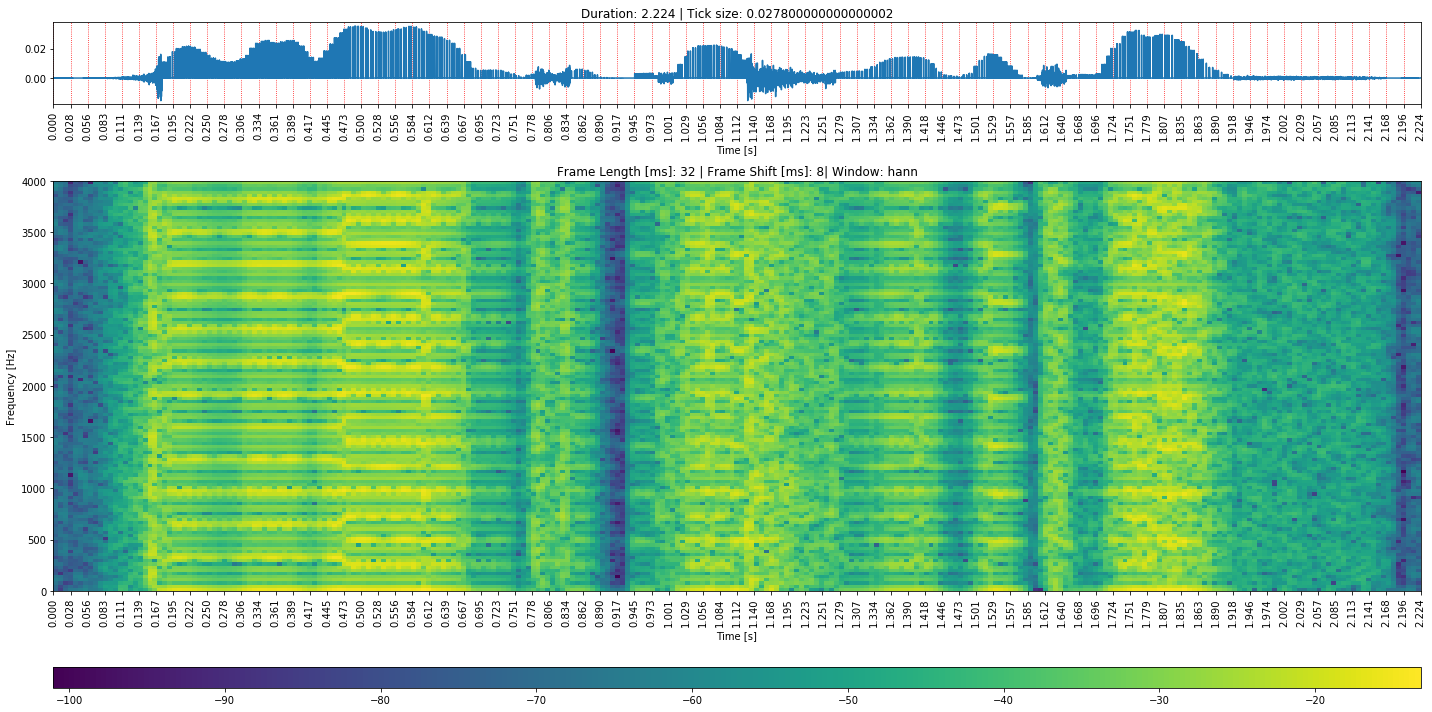

In [127]:
filter_state_out = None
output = np.array([])
# Create a counter ... 
f0_cnt = 0

_, ex_voiced_frames = ex_voiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_voiced_frames = ex_voiced_frames
_, ex_unvoiced_frames = ex_unvoiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_unvoiced_frames = ex_unvoiced_frames

fund_freq = female.estimate_fundamental_freq(frame_length_ms=8, frame_shift_ms=8)

for voiced_frame, unvoiced_frame, lpc, voiced, p, f0 in zip(ex_voiced_frames, ex_unvoiced_frames, lpcs, is_voiced, power, fund_freq):
    # voiced unvoiced decision
    frame = unvoiced_frame
    if voiced == 1:
        frame = voiced_frame
        # variable f0
        for i in range(len(voiced_frame)):
            # ... that you increase for every sample of a voiced segment.
            f0_cnt += 1
            # Test if the counter is larger than the current fundamental period in samples.
            if f0_cnt > utils.hz_to_idx(f0, female.sampling_freq):
                # Every time this is the case, set the counter to zero ...
                f0_cnt = 0
                # ... and insert a pulse into the excitation signal at the
                # corresponding sample of the segment.
                frame[i] = 1
                
    # create synthesized signal by convolving the excitation signal with the vocal tract filter (from the lpcs) 
    signal_out, filter_state_out = utils.filter_adaptively(np.array([1]), np.array([1]), frame, filter_state_out)
    
    # account for amplitude mod / gain
    signal_out = np.sqrt(p) * signal_out
    
    output = np.append(output, signal_out)

output_sig = AudioSignal(data=output, sampling_freq_hz=8000)
output_sig.play()
output_sig.plot_stft(frame_length_ms=32, frame_shift_ms=8)